# 프로젝트 : HPE 모델 비교
2024-07-19 이경규

<br>

### 데이터 : MPII
### 모델 : Stacked Hourglass Network / SimpleBaseline
### 목표 : Human Pose Estimation 모델 성능 비교

### 0. 라이브러리

In [2]:
# 주의! ray를 tensorflow보다 먼저 import하면 오류가 발생
import io, json, os, math

import tensorflow as tf
from tensorflow.keras.layers import Add, Concatenate, Lambda
from tensorflow.keras.layers import Input, Conv2D, ReLU, MaxPool2D
from tensorflow.keras.layers import UpSampling2D, ZeroPadding2D
from tensorflow.keras.layers import BatchNormalization
import ray

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

PROJECT_PATH = os.getenv('HOME') + '/aiffel/mpii'
IMAGE_PATH = os.path.join(PROJECT_PATH, 'images')
MODEL_PATH = os.path.join(PROJECT_PATH, 'models')
TFRECORD_PATH = os.path.join(PROJECT_PATH, 'tfrecords_mpii')
TRAIN_JSON = os.path.join(PROJECT_PATH, 'mpii_human_pose_v1_u12_2', 'train.json')
VALID_JSON = os.path.join(PROJECT_PATH, 'mpii_human_pose_v1_u12_2', 'validation.json')

## 1. TFRecord
### 1.1 JSON 파싱
- `anno` : JSON 파일에서 파싱한 데이터
- 파일 이름, 파일 경로, 관절 가시성 정보, 관절 좌표, 중심 좌표, 스케일 정보

In [3]:
def parse_one_annotation(anno, image_dir):
    filename = anno['image']
    joints = anno['joints']
    joints_visibility = anno['joints_vis']
    annotation = {
        'filename': filename,
        'filepath': os.path.join(image_dir, filename),
        'joints_visibility': joints_visibility,
        'joints': joints,
        'center': anno['center'],
        'scale' : anno['scale']
    }
    return annotation

### 1.2 TFRecord 파일 생성 함수
[tf.data API로 성능 향상하기](https://www.tensorflow.org/guide/data_performance?hl=ko)

[TFRecord 및 tf.train.Example](https://www.tensorflow.org/tutorials/load_data/tfrecord?hl=ko)

- 이미지 파일, 주석 데이터를 받아 TFRecord 파일에 저장할 수 있는 `tr.train.Example` 객체로 변환 → TensorFlow 데이터 파이프라인에서 효율적으로 사용
    - TFRecord : binary record sequence를 저장하기 위한 형식
1. `_bytes_feature()` :
    1. **목적**: 바이트 값을 `tf.train.Feature` 형식으로 변환
    2. **동작**: 텐서 객체인 경우 `numpy` 메서드를 사용하여 바이트 값으로 변환한 후 `tf.train.BytesList` 객체를 생성
2. **이미지 파일 읽기 및 처리**
    1. **목적**: 이미지 파일을 읽고 JPEG 형식으로 변환하여 바이트 콘텐츠를 추출
    2. **동작**: 이미지를 파일 경로에서 읽어오고, JPEG 형식이 아니거나 RGB 모드가 아닌 경우 변환한 후, 바이트 데이터를 추출
3. **이미지 메타데이터 추출**
    1. **목적**: 이미지의 너비, 높이 및 깊이(채널 수)를 추출
    2. **동작**: PIL 라이브러리를 사용하여 이미지의 크기를 얻고, RGB 모드이므로 깊이는 3으로 설정
4. **주석 데이터 변환**
    1. **목적**: 주석 데이터에서 중심 좌표, 스케일, 관절 좌표(x, y) 및 가시성 데이터를 추출하고 변환
    2. **동작**: 주석 데이터를 적절한 형식(int 또는 float)으로 변환
5. **TFRecord 예제 생성**
    1. **목적**: 추출된 데이터를 `tf.train.Feature` 형식으로 변환하여 딕셔너리에 저장
    2. **동작**: `tf.train.Features` 객체를 생성하고 이를 사용하여 `tf.train.Example` 객체를 생성

In [4]:
def generate_tfexample(anno):

    # byte 인코딩을 위한 함수
    def _bytes_feature(value):
        if isinstance(value, type(tf.constant(0))):
            value = value.numpy()
        return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))
    # 2. 이미지 파일 읽기 및 처리
    filename = anno['filename']
    filepath = anno['filepath']
    with open(filepath, 'rb') as image_file:
        content = image_file.read()

    image = Image.open(filepath)
    if image.format != 'JPEG' or image.mode != 'RGB':
        image_rgb = image.convert('RGB')
        with io.BytesIO() as output:
            image_rgb.save(output, format="JPEG", quality=95)
            content = output.getvalue()
    
    # 3. 이미지 메타데이터 추출
    width, height = image.size
    depth = 3
    
    # 4. 주석 데이터 변환
    c_x = int(anno['center'][0])
    c_y = int(anno['center'][1])
    scale = anno['scale']

    x = [
        int(joint[0]) if joint[0] >= 0 else int(joint[0]) 
        for joint in anno['joints']
    ]
    y = [
        int(joint[1]) if joint[1] >= 0 else int(joint[0]) 
        for joint in anno['joints']
    ]

    v = [0 if joint_v == 0 else 2 for joint_v in anno['joints_visibility']]
    # 5. TFRecord 예제 생성
    feature = {
        'image/height':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[height])),
        'image/width':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[width])),
        'image/depth':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[depth])),
        'image/object/parts/x':
        tf.train.Feature(int64_list=tf.train.Int64List(value=x)),
        'image/object/parts/y':
        tf.train.Feature(int64_list=tf.train.Int64List(value=y)),
        'image/object/center/x': 
        tf.train.Feature(int64_list=tf.train.Int64List(value=[c_x])),
        'image/object/center/y': 
        tf.train.Feature(int64_list=tf.train.Int64List(value=[c_y])),
        'image/object/scale':
        tf.train.Feature(float_list=tf.train.FloatList(value=[scale])),
        'image/object/parts/v':
        tf.train.Feature(int64_list=tf.train.Int64List(value=v)),
        'image/encoded':
        _bytes_feature(content),
        'image/filename':
        _bytes_feature(filename.encode())
    }

    return tf.train.Example(features=tf.train.Features(feature=feature))

### 1.3 Shard TFRecord (1chunk)
- 전체 l개의 데이터를 n개의 그룹으로 나눔 ⇒ 1 chunk
    - 저장과 병렬 처리에 이점
- (최소 10MB 이상, 이상적으로는 100MB 이상)

In [5]:
def chunkify(l, n):
    size = len(l) // n
    start = 0
    results = []
    for i in range(n):
        results.append(l[start:start + size])
        start += size
    return results

### 1.4 Chunk to TFRecord

[RAY-병렬 처리 라이브러리](https://www.ray.io/)

- 하나의 chunk를 TFRecord로 만들어 줌

In [6]:
@ray.remote
def build_single_tfrecord(chunk, path):
    print('start to build tf records for ' + path)

    with tf.io.TFRecordWriter(path) as writer:
        for anno in chunk:
            tf_example = generate_tfexample(anno)
            writer.write(tf_example.SerializeToString())

    print('finished building tf records for ' + path)

### 2. TFRecord
- `chunkify()` : annotations를 shard로 나눔
- `futures` : chunk들을 TFRecord로 변경 (반복)

In [7]:
def build_tf_records(annotations, total_shards, split):
    chunks = chunkify(annotations, total_shards)
    futures = [
        build_single_tfrecord.remote(
            chunk, '{}/{}_{}_of_{}.tfrecords'.format(
                TFRECORD_PATH,
                split,
                str(i + 1).zfill(4),
                str(total_shards).zfill(4),
            )) for i, chunk in enumerate(chunks)
    ]
    ray.get(futures)

### 2. TFRecord 생성
- train, val 데이터에 대하여 파싱 후 TFRecord 변형
    - len(train_annotations) : 22246
    - len(val_annotations) : 2958

In [ ]:
num_train_shards = 64
num_val_shards = 8

ray.init()

print('Start to parse annotations.')
if not os.path.exists(TFRECORD_PATH):
    os.makedirs(TFRECORD_PATH)

with open(TRAIN_JSON) as train_json:
    train_annos = json.load(train_json)
    train_annotations = [
        parse_one_annotation(anno, IMAGE_PATH)
        for anno in train_annos
    ]
    print('First train annotation: ', train_annotations[0])

with open(VALID_JSON) as val_json:
    val_annos = json.load(val_json)
    val_annotations = [
        parse_one_annotation(anno, IMAGE_PATH) 
        for anno in val_annos
    ]
    print('First val annotation: ', val_annotations[0])
    
print('Start to build TF Records.')
build_tf_records(train_annotations, num_train_shards, 'train')
build_tf_records(val_annotations, num_val_shards, 'val')

print('Successfully wrote {} annotations to TF Records.'.format(
    len(train_annotations) + len(val_annotations)))

### 3. Data label
`Preprocessor()` class :
- `parse_tfexample()` : TFRecord 기반 데이터 처리
    - 모델 학습에 맞는 데이터로 변경
    - tf.io.parse_single_example() : 직렬화된 예제를 파싱 
- `crop_roi()` : Crop box 추출
    - crop_roi() : 주어진 이미지에서 관심 영역(ROI)을 잘라내고, 키포인트 좌표를 조정하여 반환
    - **입력** : 이미지와 특징(주석 데이터)
    - **출력**: 잘라낸 이미지와 새로운 키포인트 좌표
- `generate_2d_guassian()` : Gaussian분포로 Heatmap 생성
    - 특정 위치의 2D Gaussian 분포를 생성, 해당 분포를 주어진 크기의 빈 heatmap에 추가<br>
    
    - **입력** :
    
        - height, width: heatmap의 크기
        - y0, x0: Gaussian 분포의 중심 위치 (키포인트 위치)
        - visibility`: 키포인트의 가시성. 가시성이 0이면 빈 heatmap을 반환합니다
        - sigma: Gaussian 분포의 표준 편차
        - scale: Gaussian 분포의 스케일링 팩터
    
    - **출력** : heatmap : 주어진 위치에 2D Gaussian 분포를 추가한 heatmap
- `make_heatmaps()` : 주어진 키포인트 위치와 특징 데이터를 사용하여 여러 개의 heatmaps 생성
    
    - **입력** :
    
        - features: 키포인트 가시성 정보를 포함하는 딕셔너리
        - keypoint_x, keypoint_y: 키포인트의 x, y 좌표 (정규화된 값, [0, 1] 범위)
        - heatmap_shape: 생성할 heatmap의 크기와 개수를 나타내는 튜플 (height, width, num_heatmap)
    
    - **출력** : heatmaps : 모든 키포인트에 대한 2D Gaussian heatmaps를 쌓아 만든 3D 텐서 (height, width, num_heatmap)

In [8]:
from preprocess import Preprocessor

### 4. StackedHourglassNetwork
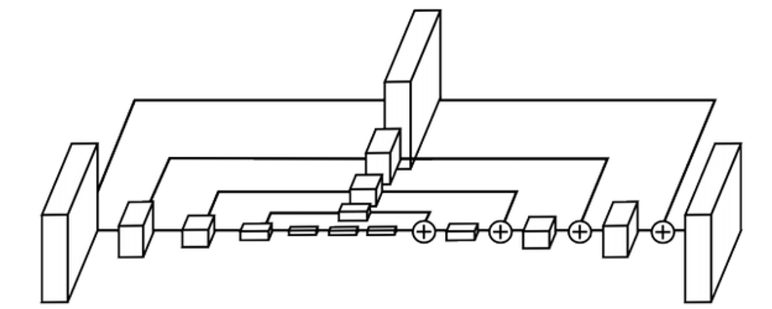


- 모래 시계 모양의 기본 구조 (feature map의 크기가 작아졌다 커지는 구조)
- **pooling** : image의 global feature → **upsampling** : local feature
1. **Conv layer, pooling** : 이미지(or feature) 인코딩
2. **upsampling layer** : feature map의 크기를 키우는 방향으로 디코딩

In [9]:
from hourglass104 import StackedHourglassNetwork
StackedHourglassNetwork().summary()

Model: "stacked_hourglass"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 64) 9472        input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_3 (BatchNor (None, 128, 128, 64) 256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
re_lu_3 (ReLU)                  (None, 128, 128, 64) 0           batch_normalization_3[0][0]      
__________________________________________________________________________________

__________________________________________________________________________________________________
max_pooling2d_16 (MaxPooling2D) (None, 4, 4, 256)    0           add_68[0][0]                     
__________________________________________________________________________________________________
batch_normalization_211 (BatchN (None, 4, 4, 256)    1024        max_pooling2d_16[0][0]           
__________________________________________________________________________________________________
re_lu_211 (ReLU)                (None, 4, 4, 256)    0           batch_normalization_211[0][0]    
__________________________________________________________________________________________________
conv2d_220 (Conv2D)             (None, 4, 4, 128)    32896       re_lu_211[0][0]                  
__________________________________________________________________________________________________
batch_normalization_212 (BatchN (None, 4, 4, 128)    512         conv2d_220[0][0]                 
__________

### 5. 학습 엔진

In [10]:
class Trainer(object):
    def __init__(self,
                 model,
                 epochs,
                 global_batch_size,
                 strategy,
                 initial_learning_rate):
        self.model = model
        self.epochs = epochs
        self.strategy = strategy
        self.global_batch_size = global_batch_size
        self.loss_object = tf.keras.losses.MeanSquaredError(
            reduction=tf.keras.losses.Reduction.NONE)
        self.optimizer = tf.keras.optimizers.Adam(
            learning_rate=initial_learning_rate)
        self.model = model

        self.current_learning_rate = initial_learning_rate
        self.last_val_loss = math.inf
        self.lowest_val_loss = math.inf
        self.patience_count = 0
        self.max_patience = 10
        self.best_model = None

    def lr_decay(self):
        if self.patience_count >= self.max_patience:
            self.current_learning_rate /= 10.0
            self.patience_count = 0
        elif self.last_val_loss == self.lowest_val_loss:
            self.patience_count = 0
        self.patience_count += 1

        self.optimizer.learning_rate = self.current_learning_rate

    def lr_decay_step(self, epoch):
        if epoch == 25 or epoch == 50 or epoch == 75:
            self.current_learning_rate /= 10.0
        self.optimizer.learning_rate = self.current_learning_rate

    def compute_loss(self, labels, outputs):
        loss = 0
        for output in outputs:
            weights = tf.cast(labels > 0, dtype=tf.float32) * 81 + 1
            loss += tf.math.reduce_mean(
                tf.math.square(labels - output) * weights) * (
                    1. / self.global_batch_size)
        return loss

    def train_step(self, inputs):
        images, labels = inputs
        with tf.GradientTape() as tape:
            outputs = self.model(images, training=True)
            loss = self.compute_loss(labels, outputs)

        grads = tape.gradient(
            target=loss, sources=self.model.trainable_variables)
        self.optimizer.apply_gradients(
            zip(grads, self.model.trainable_variables))

        return loss

    def val_step(self, inputs):
        images, labels = inputs
        outputs = self.model(images, training=False)
        loss = self.compute_loss(labels, outputs)
        return loss

    def run(self, train_dist_dataset, val_dist_dataset):
        @tf.function
        def distributed_train_epoch(dataset):
            tf.print('Start distributed traininng...')
            total_loss = 0.0
            num_train_batches = 0.0
            for one_batch in dataset:
                per_replica_loss = self.strategy.run(
                    self.train_step, args=(one_batch, ))
                batch_loss = self.strategy.reduce(
                    tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)
                total_loss += batch_loss
                num_train_batches += 1
                tf.print('Trained batch', num_train_batches, 'batch loss',
                         batch_loss, 'epoch total loss', total_loss / num_train_batches)
            return total_loss, num_train_batches

        @tf.function
        def distributed_val_epoch(dataset):
            total_loss = 0.0
            num_val_batches = 0.0
            for one_batch in dataset:
                per_replica_loss = self.strategy.run(
                    self.val_step, args=(one_batch, ))
                num_val_batches += 1
                batch_loss = self.strategy.reduce(
                    tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)
                tf.print('Validated batch', num_val_batches, 'batch loss',
                         batch_loss)
                if not tf.math.is_nan(batch_loss):
                    # TODO: Find out why the last validation batch loss become NaN
                    total_loss += batch_loss
                else:
                    num_val_batches -= 1

            return total_loss, num_val_batches

        for epoch in range(1, self.epochs + 1):
            self.lr_decay()
            print('Start epoch {} with learning rate {}'.format(
                epoch, self.current_learning_rate))

            train_total_loss, num_train_batches = distributed_train_epoch(
                train_dist_dataset)
            train_loss = train_total_loss / num_train_batches
            print('Epoch {} train loss {}'.format(epoch, train_loss))

            val_total_loss, num_val_batches = distributed_val_epoch(
                val_dist_dataset)
            val_loss = val_total_loss / num_val_batches
            print('Epoch {} val loss {}'.format(epoch, val_loss))

            # save model when reach a new lowest validation loss
            if val_loss < self.lowest_val_loss:
                self.save_model(epoch, val_loss)
                self.lowest_val_loss = val_loss
            self.last_val_loss = val_loss

        return self.best_model

    def save_model(self, epoch, loss):
        drive_path='/aiffel/aiffel/aiffel_quest/GoingDeeper/Quest8/models/'
        model_name = drive_path + 'model-epoch-{}-loss-{:.4f}.h5'.format(epoch, loss)
        self.model.save_weights(model_name)
        self.best_model = model_name
        print("Model {} saved.".format(model_name))

In [11]:
IMAGE_SHAPE = (256, 256, 3)
HEATMAP_SIZE = (64, 64)

def create_dataset(tfrecords, batch_size, num_heatmap, is_train):
    preprocess = Preprocessor(
        IMAGE_SHAPE, (HEATMAP_SIZE[0], HEATMAP_SIZE[1], num_heatmap), is_train)

    dataset = tf.data.Dataset.list_files(tfrecords)
    dataset = tf.data.TFRecordDataset(dataset)
    dataset = dataset.map(
        preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    if is_train:
        dataset = dataset.shuffle(batch_size)

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset

In [12]:
def train(epochs, learning_rate, num_heatmap, batch_size, train_tfrecords, val_tfrecords):
    strategy = tf.distribute.MirroredStrategy()
    global_batch_size = strategy.num_replicas_in_sync * batch_size
    train_dataset = create_dataset(
        train_tfrecords, global_batch_size, num_heatmap, is_train=True)
    val_dataset = create_dataset(
        val_tfrecords, global_batch_size, num_heatmap, is_train=False)

    if not os.path.exists(MODEL_PATH):
        os.makedirs(MODEL_PATH)

    with strategy.scope():
        train_dist_dataset = strategy.experimental_distribute_dataset(
            train_dataset)
        val_dist_dataset = strategy.experimental_distribute_dataset(
            val_dataset)

        model = StackedHourglassNetwork(IMAGE_SHAPE, 4, 1, num_heatmap)

        trainer = Trainer(
            model,
            epochs,
            global_batch_size,
            strategy,
            initial_learning_rate=learning_rate)

        print('Start training...')
        best_model, history = trainer.run(train_dist_dataset, val_dist_dataset)

    # history 객체 저장
    drive_path='/aiffel/aiffel/aiffel_quest/GoingDeeper/Quest8/models/'
    
    history_path = os.path.join(drive_path, 'history.pkl')
    with open(history_path, 'wb') as f:
        pickle.dump(history, f)

    # 전체 모델 저장
    model_path = os.path.join(drive_path, 'final_model.h5')
    model.save(model_path)

    return best_model

In [ ]:
train_tfrecords = os.path.join(TFRECORD_PATH, 'train*')
val_tfrecords = os.path.join(TFRECORD_PATH, 'val*')
epochs = 5
batch_size = 16
num_heatmap = 16
learning_rate = 0.0007

best_model_file = train(epochs, learning_rate, num_heatmap, batch_size, train_tfrecords, val_tfrecords)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/

/opt/conda/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:374: UserWarning: To make it possible to preserve tf.data options across serialization boundaries, their implementation has moved to be part of the TensorFlow graph. As a consequence, the options value is in general no longer known at graph construction time. Invoking this method in graph mode retains the legacy behavior of the original implementation, but note that the returned value might not reflect the actual value of the options.
  warnings.warn("To make it possible to preserve tf.data options across "


In [13]:
drive_path='/aiffel/aiffel/aiffel_quest/GoingDeeper/Quest8/models/'
WEIGHTS_PATH = os.path.join(drive_path, 'model-epoch-5-loss-1.1882.h5')

model = StackedHourglassNetwork(IMAGE_SHAPE, 4, 1)
model.load_weights(WEIGHTS_PATH)

In [15]:
R_ANKLE = 0
R_KNEE = 1
R_HIP = 2
L_HIP = 3
L_KNEE = 4
L_ANKLE = 5
PELVIS = 6
THORAX = 7
UPPER_NECK = 8
HEAD_TOP = 9
R_WRIST = 10
R_ELBOW = 11
R_SHOULDER = 12
L_SHOULDER = 13
L_ELBOW = 14
L_WRIST = 15

MPII_BONES = [
    [R_ANKLE, R_KNEE],
    [R_KNEE, R_HIP],
    [R_HIP, PELVIS],
    [L_HIP, PELVIS],
    [L_HIP, L_KNEE],
    [L_KNEE, L_ANKLE],
    [PELVIS, THORAX],
    [THORAX, UPPER_NECK],
    [UPPER_NECK, HEAD_TOP],
    [R_WRIST, R_ELBOW],
    [R_ELBOW, R_SHOULDER],
    [THORAX, R_SHOULDER],
    [THORAX, L_SHOULDER],
    [L_SHOULDER, L_ELBOW],
    [L_ELBOW, L_WRIST]
]

In [16]:
def find_max_coordinates(heatmaps):
    flatten_heatmaps = tf.reshape(heatmaps, (-1, 16))
    indices = tf.math.argmax(flatten_heatmaps, axis=0)
    y = tf.cast(indices / 64, dtype=tf.int64)
    x = indices - 64 * y
    return tf.stack([x, y], axis=1).numpy()

In [17]:
def extract_keypoints_from_heatmap(heatmaps):
    max_keypoints = find_max_coordinates(heatmaps)

    padded_heatmap = np.pad(heatmaps, [[1,1],[1,1],[0,0]], mode='constant')
    adjusted_keypoints = []
    for i, keypoint in enumerate(max_keypoints):
        max_y = keypoint[1]+1
        max_x = keypoint[0]+1
        
        patch = padded_heatmap[max_y-1:max_y+2, max_x-1:max_x+2, i]
        patch[1][1] = 0
        
        index = np.argmax(patch)
        
        next_y = index // 3
        next_x = index - next_y * 3
        delta_y = (next_y - 1) / 4
        delta_x = (next_x - 1) / 4
        
        adjusted_keypoint_x = keypoint[0] + delta_x
        adjusted_keypoint_y = keypoint[1] + delta_y
        adjusted_keypoints.append((adjusted_keypoint_x, adjusted_keypoint_y))
        
    adjusted_keypoints = np.clip(adjusted_keypoints, 0, 64)
    normalized_keypoints = adjusted_keypoints / 64
    return normalized_keypoints

In [18]:
def predict(model, image_path):
    encoded = tf.io.read_file(image_path)
    image = tf.io.decode_jpeg(encoded)
    inputs = tf.image.resize(image, (256, 256))
    inputs = tf.cast(inputs, tf.float32) / 127.5 - 1
    inputs = tf.expand_dims(inputs, 0)
    outputs = model(inputs, training=False)
    if type(outputs) != list:
        outputs = [outputs]
    heatmap = tf.squeeze(outputs[-1], axis=0).numpy()
    kp = extract_keypoints_from_heatmap(heatmap)
    return image, kp

In [19]:
def draw_keypoints_on_image(image, keypoints, index=None):
    fig,ax = plt.subplots(1)
    ax.imshow(image)
    joints = []
    for i, joint in enumerate(keypoints):
        joint_x = joint[0] * image.shape[1]
        joint_y = joint[1] * image.shape[0]
        if index is not None and index != i:
            continue
        plt.scatter(joint_x, joint_y, s=10, c='red', marker='o')
    plt.show()

def draw_skeleton_on_image(image, keypoints, index=None):
    fig,ax = plt.subplots(1)
    ax.imshow(image)
    joints = []
    for i, joint in enumerate(keypoints):
        joint_x = joint[0] * image.shape[1]
        joint_y = joint[1] * image.shape[0]
        joints.append((joint_x, joint_y))
    
    for bone in MPII_BONES:
        joint_1 = joints[bone[0]]
        joint_2 = joints[bone[1]]
        plt.plot([joint_1[0], joint_2[0]], [joint_1[1], joint_2[1]], linewidth=5, alpha=0.7)
    plt.show()

(build_single_tfrecord pid=1450) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0008_of_0064.tfrecords
(build_single_tfrecord pid=1450) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0010_of_0064.tfrecords
(build_single_tfrecord pid=1448) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0007_of_0064.tfrecords
(build_single_tfrecord pid=1448) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0011_of_0064.tfrecords


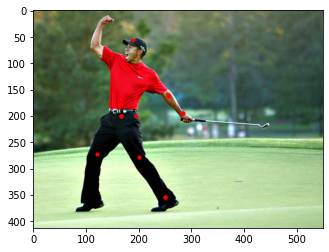

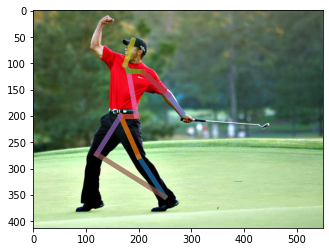

In [20]:
test_image = os.path.join(PROJECT_PATH, 'test_image.jpg')

image, keypoints = predict(model, test_image)
draw_keypoints_on_image(image, keypoints)
draw_skeleton_on_image(image, keypoints)

# Simplebaseline

In [14]:
from simplebaseline import SimpleBaseline
SimpleBaseline().summary()

Model: "simple_baseline"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, None, None, 2048)  23587712  
_________________________________________________________________
sequential_1 (Sequential)    (None, 64, 64, 256)       10489600  
_________________________________________________________________
conv2d_489 (Conv2D)          (None, 64, 64, 16)        4112      
Total params: 34,081,424
Trainable params: 34,026,768
Non-trainable params: 54,656
_________________________________________________________________


In [15]:
class Trainer(object):
    def __init__(self,
                 model,
                 epochs,
                 global_batch_size,
                 strategy,
                 initial_learning_rate):
        self.model = model
        self.epochs = epochs
        self.strategy = strategy
        self.global_batch_size = global_batch_size
        self.loss_object = tf.keras.losses.MeanSquaredError(
            reduction=tf.keras.losses.Reduction.NONE)
        self.optimizer = tf.keras.optimizers.Adam(
            learning_rate=initial_learning_rate)
        self.model = model

        self.current_learning_rate = initial_learning_rate
        self.last_val_loss = math.inf
        self.lowest_val_loss = math.inf
        self.patience_count = 0
        self.max_patience = 10
        self.best_model = None

    def lr_decay(self):
        if self.patience_count >= self.max_patience:
            self.current_learning_rate /= 10.0
            self.patience_count = 0
        elif self.last_val_loss == self.lowest_val_loss:
            self.patience_count = 0
        self.patience_count += 1

        self.optimizer.learning_rate = self.current_learning_rate

    def lr_decay_step(self, epoch):
        if epoch == 25 or epoch == 50 or epoch == 75:
            self.current_learning_rate /= 10.0
        self.optimizer.learning_rate = self.current_learning_rate

    def compute_loss(self, labels, outputs):
        loss = 0
        for output in outputs:
            weights = tf.cast(labels > 0, dtype=tf.float32) * 81 + 1
            loss += tf.math.reduce_mean(
                tf.math.square(labels - output) * weights) * (
                    1. / self.global_batch_size)
        return loss

    def train_step(self, inputs):
        images, labels = inputs
        with tf.GradientTape() as tape:
            outputs = self.model(images, training=True)
            loss = self.compute_loss(labels, outputs)

        grads = tape.gradient(
            target=loss, sources=self.model.trainable_variables)
        self.optimizer.apply_gradients(
            zip(grads, self.model.trainable_variables))

        return loss

    def val_step(self, inputs):
        images, labels = inputs
        outputs = self.model(images, training=False)
        loss = self.compute_loss(labels, outputs)
        return loss

    def run(self, train_dist_dataset, val_dist_dataset):
        @tf.function
        def distributed_train_epoch(dataset):
            tf.print('Start distributed traininng...')
            total_loss = 0.0
            num_train_batches = 0.0
            for one_batch in dataset:
                per_replica_loss = self.strategy.run(
                    self.train_step, args=(one_batch, ))
                batch_loss = self.strategy.reduce(
                    tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)
                total_loss += batch_loss
                num_train_batches += 1
                tf.print('Trained batch', num_train_batches, 'batch loss',
                         batch_loss, 'epoch total loss', total_loss / num_train_batches)
            return total_loss, num_train_batches

        @tf.function
        def distributed_val_epoch(dataset):
            total_loss = 0.0
            num_val_batches = 0.0
            for one_batch in dataset:
                per_replica_loss = self.strategy.run(
                    self.val_step, args=(one_batch, ))
                num_val_batches += 1
                batch_loss = self.strategy.reduce(
                    tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)
                tf.print('Validated batch', num_val_batches, 'batch loss',
                         batch_loss)
                if not tf.math.is_nan(batch_loss):
                    # TODO: Find out why the last validation batch loss become NaN
                    total_loss += batch_loss
                else:
                    num_val_batches -= 1

            return total_loss, num_val_batches

        for epoch in range(1, self.epochs + 1):
            self.lr_decay()
            print('Start epoch {} with learning rate {}'.format(
                epoch, self.current_learning_rate))

            train_total_loss, num_train_batches = distributed_train_epoch(
                train_dist_dataset)
            train_loss = train_total_loss / num_train_batches
            print('Epoch {} train loss {}'.format(epoch, train_loss))

            val_total_loss, num_val_batches = distributed_val_epoch(
                val_dist_dataset)
            val_loss = val_total_loss / num_val_batches
            print('Epoch {} val loss {}'.format(epoch, val_loss))

            # save model when reach a new lowest validation loss
            if val_loss < self.lowest_val_loss:
                self.save_model(epoch, val_loss)
                self.lowest_val_loss = val_loss
            self.last_val_loss = val_loss

        return self.best_model

    def save_model(self, epoch, loss):
        drive_path='/aiffel/aiffel/aiffel_quest/GoingDeeper/Quest8/model/'
        model_name = drive_path + 'model-epoch-{}-loss-{:.4f}.h5'.format(epoch, loss)
        self.model.save_weights(model_name)
        self.best_model = model_name
        print("Model {} saved.".format(model_name))

In [16]:
def train(epochs, learning_rate, num_heatmap, batch_size, train_tfrecords, val_tfrecords):
    strategy = tf.distribute.MirroredStrategy()
    global_batch_size = strategy.num_replicas_in_sync * batch_size
    train_dataset = create_dataset(
        train_tfrecords, global_batch_size, num_heatmap, is_train=True)
    val_dataset = create_dataset(
        val_tfrecords, global_batch_size, num_heatmap, is_train=False)

    if not os.path.exists(MODEL_PATH):
        os.makedirs(MODEL_PATH)

    with strategy.scope():
        train_dist_dataset = strategy.experimental_distribute_dataset(
            train_dataset)
        val_dist_dataset = strategy.experimental_distribute_dataset(
            val_dataset)

        model = SimpleBaseline(IMAGE_SHAPE, 4, 1, num_heatmap)

        trainer = Trainer(
            model,
            epochs,
            global_batch_size,
            strategy,
            initial_learning_rate=learning_rate)

        print('Start training...')
        best_model, history = trainer.run(train_dist_dataset, val_dist_dataset)

    # history 객체 저장
    drive_path='/aiffel/aiffel/aiffel_quest/GoingDeeper/Quest8/model/'
    
    history_path = os.path.join(drive_path, 'history.pkl')
    with open(history_path, 'wb') as f:
        pickle.dump(history, f)

    # 전체 모델 저장
    model_path = os.path.join(drive_path, 'final_model.h5')
    model.save(model_path)

    return best_model

In [ ]:
train_tfrecords = os.path.join(TFRECORD_PATH, 'train*')
val_tfrecords = os.path.join(TFRECORD_PATH, 'val*')
epochs = 5
batch_size = 16
num_heatmap = 16
learning_rate = 0.0007

best_model_file = train(epochs, learning_rate, num_heatmap, batch_size, train_tfrecords, val_tfrecords)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/

/opt/conda/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:374: UserWarning: To make it possible to preserve tf.data options across serialization boundaries, their implementation has moved to be part of the TensorFlow graph. As a consequence, the options value is in general no longer known at graph construction time. Invoking this method in graph mode retains the legacy behavior of the original implementation, but note that the returned value might not reflect the actual value of the options.
  warnings.warn("To make it possible to preserve tf.data options across "


Start distributed traininng...
Trained batch 1 batch loss 2.79155493 epoch total loss 2.79155493
Trained batch 2 batch loss 2.70016956 epoch total loss 2.74586225
Trained batch 3 batch loss 2.57169271 epoch total loss 2.68780589
Trained batch 4 batch loss 2.48612213 epoch total loss 2.63738489
Trained batch 5 batch loss 2.47835088 epoch total loss 2.60557795
Trained batch 6 batch loss 2.31698513 epoch total loss 2.55747914
Trained batch 7 batch loss 2.34454226 epoch total loss 2.52705956
Trained batch 8 batch loss 2.22373867 epoch total loss 2.48914433
Trained batch 9 batch loss 2.19440293 epoch total loss 2.45639515
Trained batch 10 batch loss 2.22328424 epoch total loss 2.43308401
Trained batch 11 batch loss 2.15958858 epoch total loss 2.40822077
Trained batch 12 batch loss 2.03736377 epoch total loss 2.377316
Trained batch 13 batch loss 2.15264893 epoch total loss 2.36003399
Trained batch 14 batch loss 2.07477689 epoch total loss 2.3396585
Trained batch 15 batch loss 2.05294013 epoc

Trained batch 124 batch loss 1.77931535 epoch total loss 1.80464935
Trained batch 125 batch loss 1.75443113 epoch total loss 1.80424762
Trained batch 126 batch loss 1.656021 epoch total loss 1.80307114
Trained batch 127 batch loss 1.6750145 epoch total loss 1.80206287
Trained batch 128 batch loss 1.68081582 epoch total loss 1.80111563
Trained batch 129 batch loss 1.53869009 epoch total loss 1.79908133
Trained batch 130 batch loss 1.56248796 epoch total loss 1.79726136
Trained batch 131 batch loss 1.69974577 epoch total loss 1.79651701
Trained batch 132 batch loss 1.72473347 epoch total loss 1.79597318
Trained batch 133 batch loss 1.59037185 epoch total loss 1.79442739
Trained batch 134 batch loss 1.64010262 epoch total loss 1.79327571
Trained batch 135 batch loss 1.71705377 epoch total loss 1.79271114
Trained batch 136 batch loss 1.70146382 epoch total loss 1.79204023
Trained batch 137 batch loss 1.67032 epoch total loss 1.79115176
Trained batch 138 batch loss 1.65511572 epoch total lo

Trained batch 245 batch loss 1.61834335 epoch total loss 1.72702122
Trained batch 246 batch loss 1.59394372 epoch total loss 1.72648025
Trained batch 247 batch loss 1.56765342 epoch total loss 1.72583723
Trained batch 248 batch loss 1.58214355 epoch total loss 1.72525787
Trained batch 249 batch loss 1.64486635 epoch total loss 1.72493505
Trained batch 250 batch loss 1.6403811 epoch total loss 1.72459686
Trained batch 251 batch loss 1.61500692 epoch total loss 1.72416019
Trained batch 252 batch loss 1.71509647 epoch total loss 1.72412419
Trained batch 253 batch loss 1.66388464 epoch total loss 1.72388613
Trained batch 254 batch loss 1.58261597 epoch total loss 1.7233299
Trained batch 255 batch loss 1.59221959 epoch total loss 1.72281575
Trained batch 256 batch loss 1.62599421 epoch total loss 1.72243762
Trained batch 257 batch loss 1.63931215 epoch total loss 1.72211421
Trained batch 258 batch loss 1.52010012 epoch total loss 1.72133124
Trained batch 259 batch loss 1.60162938 epoch tota

Trained batch 366 batch loss 1.60865712 epoch total loss 1.68724823
Trained batch 367 batch loss 1.57745743 epoch total loss 1.68694901
Trained batch 368 batch loss 1.5599556 epoch total loss 1.6866039
Trained batch 369 batch loss 1.5698688 epoch total loss 1.68628752
Trained batch 370 batch loss 1.60709369 epoch total loss 1.68607354
Trained batch 371 batch loss 1.48142266 epoch total loss 1.68552208
Trained batch 372 batch loss 1.53910959 epoch total loss 1.68512845
Trained batch 373 batch loss 1.50432837 epoch total loss 1.68464375
Trained batch 374 batch loss 1.53582144 epoch total loss 1.68424582
Trained batch 375 batch loss 1.53187037 epoch total loss 1.68383956
Trained batch 376 batch loss 1.61537981 epoch total loss 1.68365741
Trained batch 377 batch loss 1.54947555 epoch total loss 1.68330157
Trained batch 378 batch loss 1.60326231 epoch total loss 1.68308985
Trained batch 379 batch loss 1.50372136 epoch total loss 1.68261659
Trained batch 380 batch loss 1.56627584 epoch total

### 회고
- 배운점: HPE의 동작방식과 Hourglass의 downsampling, upsampling에 대해 알 수 있었다 
- 아쉬운점: 프로젝트를 완성하지 못한점이 아쉽다. 다른 모델들에도 적용해보고 싶었다.
- 느낀점: 모델이 단순해지더라도 성능이 나빠지지 않을 수 있다.
- 어려웠던점: simplebaseline 모델이 heatmap이 아닌 x,y좌표를 예측하는 것으로 착각했었습니다.